In [224]:
#from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Assuming the Excel file is named 'data.xlsx' and located in the current directory
file_path ="EAH_Database_all.xlsx"
df = pd.read_excel(file_path)

#replacing any statistical outliers with mean values
outlier_cols=[
       'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g','v1_freddy_pre_eah']

In [225]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)


{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 1, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 1, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0}


In [226]:
def remove_subjects_with_outliers(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Filter out rows where outliers exist in the specified columns
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Usage
outlier_cols = ['mvpa_simple_avg','sed_simple_avg']
df = remove_subjects_with_outliers(df, outlier_cols)

In [227]:
# Filtering the dataset for subjects with actual values in the specified columns
filtered_df = df.dropna(subset=['mvpa_simple_avg','sed_simple_avg'])

# Printing the first few rows of the filtered dataset to confirm
print(filtered_df[['mvpa_simple_avg','sed_simple_avg']].head())

# You can also get the count of remaining subjects
remaining_subjects_count = filtered_df.shape[0]
print(f"Number of subjects with actual values: {remaining_subjects_count}")

   mvpa_simple_avg  sed_simple_avg
0       354.722222      608.388889
1       484.027778      812.777778
2       473.333333      824.261905
5       396.366667      429.666667
6       478.571429      724.583333
Number of subjects with actual values: 65


In [228]:
df_no_outliers=filtered_df.copy()

In [229]:
df_no_outliers.head()

,id,item clean,Audio mode,v1_date,v7_date,bmi_screenout,parent_respondent,measured_parent,risk_status_mom,sex,...,v1_LMI,v7_LMI,total_mvpa_avg,met_avg,percent_mvpa_avg,sedentary_avg,percent_sedentary_avg,sed_simple_avg,avg_wear_time,mvpa_simple_avg
0,1.0,0,H,2018-01-31,2019-07-05,0,0,0,1,0,...,10.90,11.0,419.040000,2.277766,32.330000,675.471182,61.966667,608.388889,1023.666667,354.722222
1,2.0,1,H,2018-02-19,2019-05-16,0,0,0,0,0,...,10.60,10.6,485.007246,2.282391,35.395000,824.239130,58.561667,812.777778,1380.000000,484.027778
2,3.0,0,H,2018-02-15,2019-09-11,0,0,0,0,1,...,9.84,10.7,473.974347,2.238248,34.387143,830.879942,59.391429,824.261905,1383.857143,473.333333
5,7.0,0,H,2018-06-06,2019-09-13,0,1,1,0,1,...,10.10,11.1,420.821274,2.699506,46.814000,501.521281,45.182000,429.666667,892.800000,396.366667
6,9.0,0,H,2018-06-05,2019-08-21,0,0,0,0,0,...,10.60,10.9,478.118952,2.371717,35.805714,734.924939,53.277143,724.583333,1351.285714,478.571429


# sex differences in MVPA and sed

In [230]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Descriptive statistics
desc_stats_mvpa = df_no_outliers.groupby('sex')['mvpa_simple_avg'].describe()
desc_stats_sed = df_no_outliers.groupby('sex')['sed_simple_avg'].describe()

# Independent Samples t-test for MVPA
t_stat_mvpa, p_value_mvpa = stats.ttest_ind(df_no_outliers[df_no_outliers['sex'] == 0]['mvpa_simple_avg'], df_no_outliers[df_no_outliers['sex'] == 1]['mvpa_simple_avg'])

# Independent Samples t-test for Sedentary Time
t_stat_sed, p_value_sed = stats.ttest_ind(df_no_outliers[df_no_outliers['sex'] == 0]['sed_simple_avg'], df_no_outliers[df_no_outliers['sex'] == 1]['sed_simple_avg'])

# Print results
print(f"MVPA - t-statistic: {t_stat_mvpa}, p-value: {p_value_mvpa}")
print(f"Sedentary Time - t-statistic: {t_stat_sed}, p-value: {p_value_sed}")

# Calculate effect size (Cohen's d)
mean_diff_mvpa = df_no_outliers[df_no_outliers['sex'] == 0]['mvpa_simple_avg'].mean() - df_no_outliers[df_no_outliers['sex'] == 1]['mvpa_simple_avg'].mean()
pooled_std_mvpa = np.sqrt(((df_no_outliers[df_no_outliers['sex'] == 0]['mvpa_simple_avg'].std() ** 2) + (df_no_outliers[df_no_outliers['sex'] == 1]['mvpa_simple_avg'].std() ** 2)) / 2)
cohen_d_mvpa = mean_diff_mvpa / pooled_std_mvpa

mean_diff_sed = df_no_outliers[df_no_outliers['sex'] == 0]['sed_simple_avg'].mean() - df_no_outliers[df_no_outliers['sex'] == 1]['sed_simple_avg'].mean()
pooled_std_sed = np.sqrt(((df_no_outliers[df_no_outliers['sex'] == 0]['sed_simple_avg'].std() ** 2) + (df_no_outliers[df_no_outliers['sex'] == 1]['sed_simple_avg'].std() ** 2)) / 2)
cohen_d_sed = mean_diff_sed / pooled_std_sed

print(f"Cohen's d for MVPA: {cohen_d_mvpa}")
print(f"Cohen's d for Sedentary Time: {cohen_d_sed}")


MVPA - t-statistic: -0.2279379233826477, p-value: 0.8204326746898785
Sedentary Time - t-statistic: 0.5538529207023996, p-value: 0.5816400669650618
Cohen's d for MVPA: -0.056697618050220826
Cohen's d for Sedentary Time: 0.13708477042183007


# Moderation by median split of PA (%mvpa and total mvpa, averaged), risk status : EAH_sweet_kcal

In [231]:
import pandas as pd

# df_no_outliers is your DataFrame
mean_sd_stats = df_no_outliers[['mvpa_simple_avg','sed_simple_avg']].agg(['mean', 'std', 'min', 'max'])

# Formatting the output to two decimal places
mean_sd_stats = mean_sd_stats.map(lambda x: f"{x:.2f}")

print(mean_sd_stats)

     mvpa_simple_avg sed_simple_avg
mean          429.28         754.04
std            67.17          96.22
min           240.71         429.67
max           575.74         927.40


In [232]:
# Perform the median split on 'Total MVPA'
median_total_mvpa = df_no_outliers['mvpa_simple_avg'].median()
median_sedentary = df_no_outliers['sed_simple_avg'].median()
df_no_outliers['median_split_total_mvpa'] = np.where(df_no_outliers['mvpa_simple_avg'] > median_total_mvpa, 1, 0)
df_no_outliers['median_split_sedentary'] = np.where(df_no_outliers['sed_simple_avg'] > median_sedentary, 1, 0)

In [233]:
# Cross-tabulate the groups based on the median splits
grouped_df = df_no_outliers.groupby(['median_split_total_mvpa', 'median_split_sedentary'])

# Calculate mean and standard deviation for each group
mean_sd_df = grouped_df.agg(
    mean_mvpa=('mvpa_simple_avg', 'mean'),
    sd_mvpa=('mvpa_simple_avg', 'std'),
    mean_sedentary=('sed_simple_avg', 'mean'),
    sd_sedentary=('sed_simple_avg', 'std')
).reset_index()

# Display the result
mean_sd_df

,median_split_total_mvpa,median_split_sedentary,mean_mvpa,sd_mvpa,mean_sedentary,sd_sedentary
0,0,0,372.169260,51.949580,632.099135,80.885235
1,0,1,381.055190,42.121581,844.215330,44.840541
2,1,0,493.198747,41.273575,716.283427,45.687453
3,1,1,467.824634,18.980636,808.770452,20.439122


In [234]:
import pandas as pd
from scipy.stats import f_oneway

# Cross-tabulate the groups based on the median splits
crosstab_df = pd.crosstab(df_no_outliers['median_split_total_mvpa'], df_no_outliers['median_split_sedentary'])

# Calculate mean and standard deviation for each group
mean_sd_df = grouped_df.agg(
    mean_mvpa=('mvpa_simple_avg', 'mean'),
    sd_mvpa=('mvpa_simple_avg', 'std'),
    mean_sedentary=('sed_simple_avg', 'mean'),
    sd_sedentary=('sed_simple_avg', 'std')
).reset_index()

# Perform ANOVA to assess significant differences between MVPA and sedentary across the four groups
anova_mvpa = f_oneway(
    df_no_outliers[df_no_outliers['median_split_total_mvpa'] == 0]['mvpa_simple_avg'],
    df_no_outliers[df_no_outliers['median_split_total_mvpa'] == 1]['mvpa_simple_avg']
)

anova_sedentary = f_oneway(
    df_no_outliers[df_no_outliers['median_split_sedentary'] == 0]['sed_simple_avg'],
    df_no_outliers[df_no_outliers['median_split_sedentary'] == 1]['sed_simple_avg']
)

# Display the results
print("Cross-tabulation of Groups Based on Median Splits:")
print(crosstab_df.to_string())

print("\nMean and Standard Deviation for Each Group:")
for index, row in mean_sd_df.iterrows():
    print(f"\nGroup MVPA: {row['median_split_total_mvpa']}, Sedentary: {row['median_split_sedentary']}")
    print(f"Mean MVPA: {row['mean_mvpa']:.2f} ± {row['sd_mvpa']:.2f}")
    print(f"Mean Sedentary: {row['mean_sedentary']:.2f} ± {row['sd_sedentary']:.2f}")

# Display the ANOVA results
print("\nANOVA Results:")
print(f"MVPA ANOVA: F-statistic = {anova_mvpa.statistic:.2f}, p-value = {anova_mvpa.pvalue:.4f}")
print(f"Sedentary ANOVA: F-statistic = {anova_sedentary.statistic:.2f}, p-value = {anova_sedentary.pvalue:.4f}")


Cross-tabulation of Groups Based on Median Splits:
median_split_sedentary    0   1
median_split_total_mvpa        
0                        14  19
1                        19  13

Mean and Standard Deviation for Each Group:

Group MVPA: 0.0, Sedentary: 0.0
Mean MVPA: 372.17 ± 51.95
Mean Sedentary: 632.10 ± 80.89

Group MVPA: 0.0, Sedentary: 1.0
Mean MVPA: 381.06 ± 42.12
Mean Sedentary: 844.22 ± 44.84

Group MVPA: 1.0, Sedentary: 0.0
Mean MVPA: 493.20 ± 41.27
Mean Sedentary: 716.28 ± 45.69

Group MVPA: 1.0, Sedentary: 1.0
Mean MVPA: 467.82 ± 18.98
Mean Sedentary: 808.77 ± 20.44

ANOVA Results:
MVPA ANOVA: F-statistic = 106.07, p-value = 0.0000
Sedentary ANOVA: F-statistic = 98.84, p-value = 0.0000


In [235]:
from scipy.stats import ttest_ind
# Columns to test
columns_to_test = [
    'v1_eah_kcal', 'v1_meal_kcal', 'v1_eah_sweet_kcal', 'v1_eah_sav_kcal', 'v1_eah_g', 'v1_meal_g', 
    'v1_eah_sweet_g', 'v1_eah_sav_g', 'v7_eah_kcal', 'v7_meal_kcal', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal', 
    'v7_eah_g', 'v7_meal_g', 'v7_eah_sweet_g', 'v7_eah_sav_g'
]

from itertools import combinations
from scipy.stats import ttest_ind
import pandas as pd

# Function to perform t-tests and collect results for 4 groups
def perform_ttests_four_groups(df, group1_col, group2_col, test_cols):
    results = []
    
    # Create a column for the 4 groups
    df['group'] = df[group1_col].astype(str) + df[group2_col].astype(str)
    
    # Generate all combinations of groups
    group_combinations = list(combinations(df['group'].unique(), 2))
    
    for col in test_cols:
        for (group1_label, group2_label) in group_combinations:
            group1 = df[df['group'] == group1_label]
            group2 = df[df['group'] == group2_label]
            
            t_stat, p_val = ttest_ind(group1[col], group2[col], nan_policy='omit')
            mean1, mean2 = group1[col].mean(), group2[col].mean()
            sd1, sd2 = group1[col].std(), group2[col].std()
            range1, range2 = (group1[col].min(), group1[col].max()), (group2[col].min(), group2[col].max())
            n1, n2 = group1[col].count(), group2[col].count()
            
            results.append({
                'Variable': col, 
                'Group1_Label': group1_label,
                'Group2_Label': group2_label,
                't-Statistic': t_stat, 
                'p-Value': p_val,
                'Group1_Mean': mean1, 
                'Group2_Mean': mean2,
                'Group1_SD': sd1, 
                'Group2_SD': sd2,
                'Group1_Range': range1, 
                'Group2_Range': range2,
                'Group1_N': n1, 
                'Group2_N': n2
            })
    
    return pd.DataFrame(results)

# Perform t-tests across the 4 groups
ttest_results_four_groups = perform_ttests_four_groups(df_no_outliers, 'median_split_total_mvpa', 'median_split_sedentary', columns_to_test)

# Print results
print(ttest_results_four_groups)

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Display the full results
with pd.option_context('display.max_columns', None):
    display(ttest_results_four_groups)

# Optionally, reset the max_rows option if you don't want it to affect other outputs
pd.reset_option('display.max_rows')


        Variable Group1_Label Group2_Label  t-Statistic   p-Value  \
0    v1_eah_kcal           00           11     0.200603  0.842632   
1    v1_eah_kcal           00           10    -1.093447  0.282622   
2    v1_eah_kcal           00           01    -0.448851  0.656661   
3    v1_eah_kcal           11           10    -1.301914  0.202854   
4    v1_eah_kcal           11           01    -0.670336  0.507771   
..           ...          ...          ...          ...       ...   
91  v7_eah_sav_g           00           10     0.169166  0.866765   
92  v7_eah_sav_g           00           01    -0.632462  0.531722   
93  v7_eah_sav_g           11           10     0.240236  0.811782   
94  v7_eah_sav_g           11           01    -0.372124  0.712417   
95  v7_eah_sav_g           10           01    -0.728731  0.470881   

    Group1_Mean  Group2_Mean   Group1_SD   Group2_SD  \
0    248.419085   239.281439  123.793976  111.963713   
1    248.419085   299.271327  123.793976  137.684006   
2  

,Variable,Group1_Label,Group2_Label,t-Statistic,p-Value,Group1_Mean,Group2_Mean,Group1_SD,Group2_SD,Group1_Range,Group2_Range,Group1_N,Group2_N
0,v1_eah_kcal,00,11,0.200603,0.842632,248.419085,239.281439,123.793976,111.963713,"(60.37430999999995, 569.6712999999997)","(95.58554999999998, 472.1075900000002)",14,13
1,v1_eah_kcal,00,10,-1.093447,0.282622,248.419085,299.271327,123.793976,137.684006,"(60.37430999999995, 569.6712999999997)","(115.7176400000001, 624.3489099999998)",14,19
2,v1_eah_kcal,00,01,-0.448851,0.656661,248.419085,267.908411,123.793976,122.900544,"(60.37430999999995, 569.6712999999997)","(65.80187999999997, 552.9737)",14,19
3,v1_eah_kcal,11,10,-1.301914,0.202854,239.281439,299.271327,111.963713,137.684006,"(95.58554999999998, 472.1075900000002)","(115.7176400000001, 624.3489099999998)",13,19
4,v1_eah_kcal,11,01,-0.670336,0.507771,239.281439,267.908411,111.963713,122.900544,"(95.58554999999998, 472.1075900000002)","(65.80187999999997, 552.9737)",13,19
5,v1_eah_kcal,10,01,0.740733,0.463660,299.271327,267.908411,137.684006,122.900544,"(115.7176400000001, 624.3489099999998)","(65.80187999999997, 552.9737)",19,19
6,v1_meal_kcal,00,11,1.930125,0.065011,646.414575,443.575274,270.356645,275.521156,"(279.8656500000001, 1098.4737700000003)","(55.81333999999999, 1149.93785)",14,13
7,v1_meal_kcal,00,10,0.370871,0.713256,646.414575,610.537059,270.356645,277.713444,"(279.8656500000001, 1098.4737700000003)","(137.0, 1200.1792999999998)",14,19
8,v1_meal_kcal,00,01,0.798734,0.430522,646.414575,573.235694,270.356645,252.462118,"(279.8656500000001, 1098.4737700000003)","(219.67092000000005, 1125.12447)",14,19
9,v1_meal_kcal,11,10,-1.675575,0.104215,443.575274,610.537059,275.521156,277.713444,"(55.81333999999999, 1149.93785)","(137.0, 1200.1792999999998)",13,19


In [236]:
# Standardize the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_columns = ['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']
df_no_outliers[scaled_columns] = scaler.fit_transform(df_no_outliers[scaled_columns])

# Save the original scaled data for plotting
df_unscaled = df_no_outliers.copy()


# Inverse transform the scaled variables for plotting
df_unscaled[['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']] = scaler.inverse_transform(df_unscaled[scaled_columns])

In [237]:
# Recoding the income column
df_no_outliers['income'] = df_no_outliers['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_no_outliers['parent_ed'] = df_no_outliers['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

In [238]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_no_outliers['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_no_outliers.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_no_outliers = pd.concat([df_no_outliers, tanner_dummies], axis=1)

# sex diff in median split (chi sq of indp)

In [239]:
import pandas as pd
from scipy.stats import chi2_contingency

# Contingency table for median_split_total_mvpa
contingency_table_mvpa = pd.crosstab(df_no_outliers['sex'], df_no_outliers['median_split_total_mvpa'])

# Chi-square test for median_split_total_mvpa
chi2_mvpa, p_mvpa, dof_mvpa, ex_mvpa = chi2_contingency(contingency_table_mvpa)

print("Chi-square test for median_split_total_mvpa:")
print(f"Chi-square statistic: {chi2_mvpa}, p-value: {p_mvpa}")

# Contingency table for median_split_sedentary
contingency_table_sedentary = pd.crosstab(df_no_outliers['sex'], df_no_outliers['median_split_sedentary'])

# Chi-square test for median_split_sedentary
chi2_sedentary, p_sedentary, dof_sedentary, ex_sedentary = chi2_contingency(contingency_table_sedentary)

print("Chi-square test for median_split_sedentary:")
print(f"Chi-square statistic: {chi2_sedentary}, p-value: {p_sedentary}")


Chi-square test for median_split_total_mvpa:
Chi-square statistic: 0.3784430973635789, p-value: 0.5384376442362945
Chi-square test for median_split_sedentary:
Chi-square statistic: 0.014030470142602496, p-value: 0.9057108840917619


# three way models overall

In [240]:
import statsmodels.formula.api as smf

# Fit the regression model
model_total_mvpa_sed_meal_kcal = smf.ols(
    'v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + '
    'v7_p_pds_imputed_3 + age_diff + avg_wear_time + v1_meal_kcal * median_split_total_mvpa * median_split_sedentary',
    data=df_no_outliers
).fit()

# Print the summary to see the p-values
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_sed_meal_kcal.summary())

# Extract and compare p-values for the interaction terms
interaction_pvalues = model_total_mvpa_sed_meal_kcal.pvalues.filter(like='v1_meal_kcal:median_split_total_mvpa')

# Display the p-values for each interaction term
print("\nP-Values for Interaction Terms:")
print(interaction_pvalues)

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     17.70
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           6.78e-15
Time:                        15:58:49   Log-Likelihood:                -29.453
No. Observations:                  65   AIC:                             92.91
Df Residuals:                      48   BIC:                             129.9
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [241]:
# Fit regression models
model_total_mvpa_sed_eah_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_kcal*median_split_total_mvpa*median_split_sedentary', data=df_no_outliers).fit()

# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_sed_eah_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     20.07
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.67e-16
Time:                        15:58:49   Log-Likelihood:                -25.938
No. Observations:                  65   AIC:                             85.88
Df Residuals:                      48   BIC:                             122.8
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [242]:
# Fit regression models
model_total_mvpa_sed_eah_sweet_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal*median_split_total_mvpa*median_split_sedentary', data=df_no_outliers).fit()
# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_sed_eah_sweet_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     20.16
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.20e-16
Time:                        15:58:49   Log-Likelihood:                -25.814
No. Observations:                  65   AIC:                             85.63
Df Residuals:                      48   BIC:                             122.6
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [243]:
# Fit regression models
model_total_mvpa_sed_eah_sav_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sav_kcal*median_split_total_mvpa*median_split_sedentary', data=df_no_outliers).fit()
# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_sed_eah_sav_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     17.91
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.37e-15
Time:                        15:58:49   Log-Likelihood:                -29.122
No. Observations:                  65   AIC:                             92.24
Df Residuals:                      48   BIC:                             129.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

# Graphs

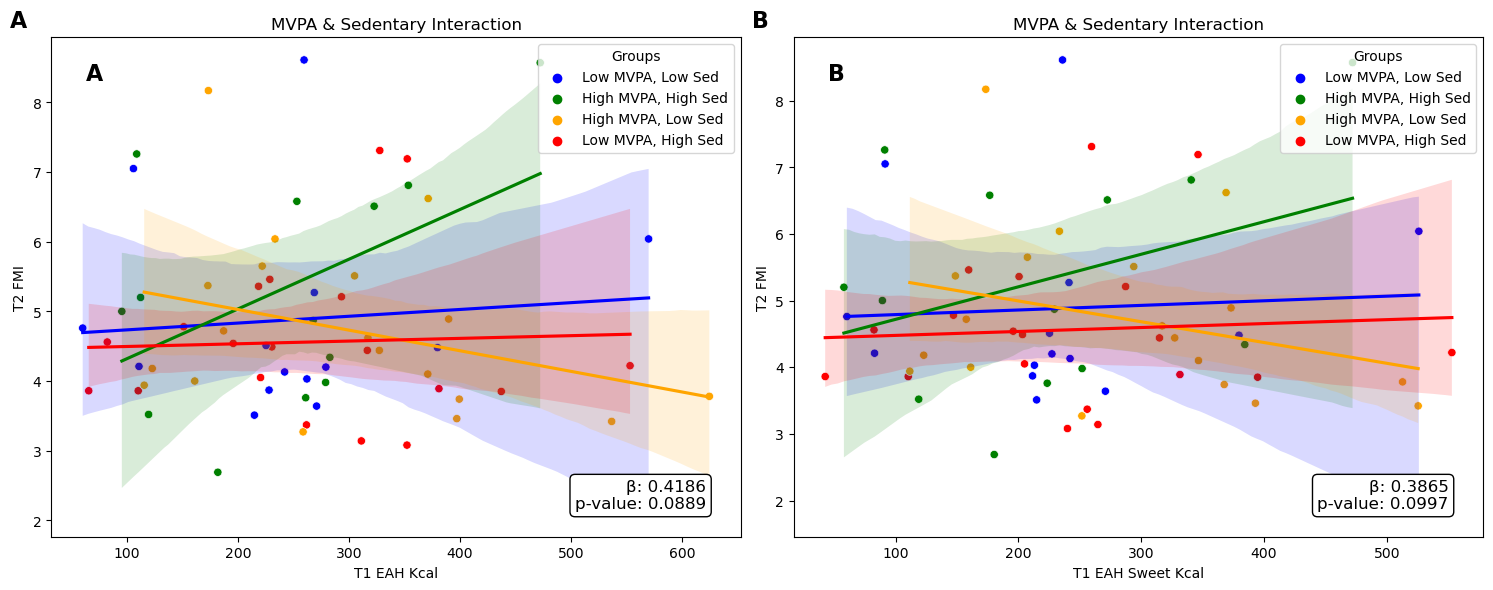

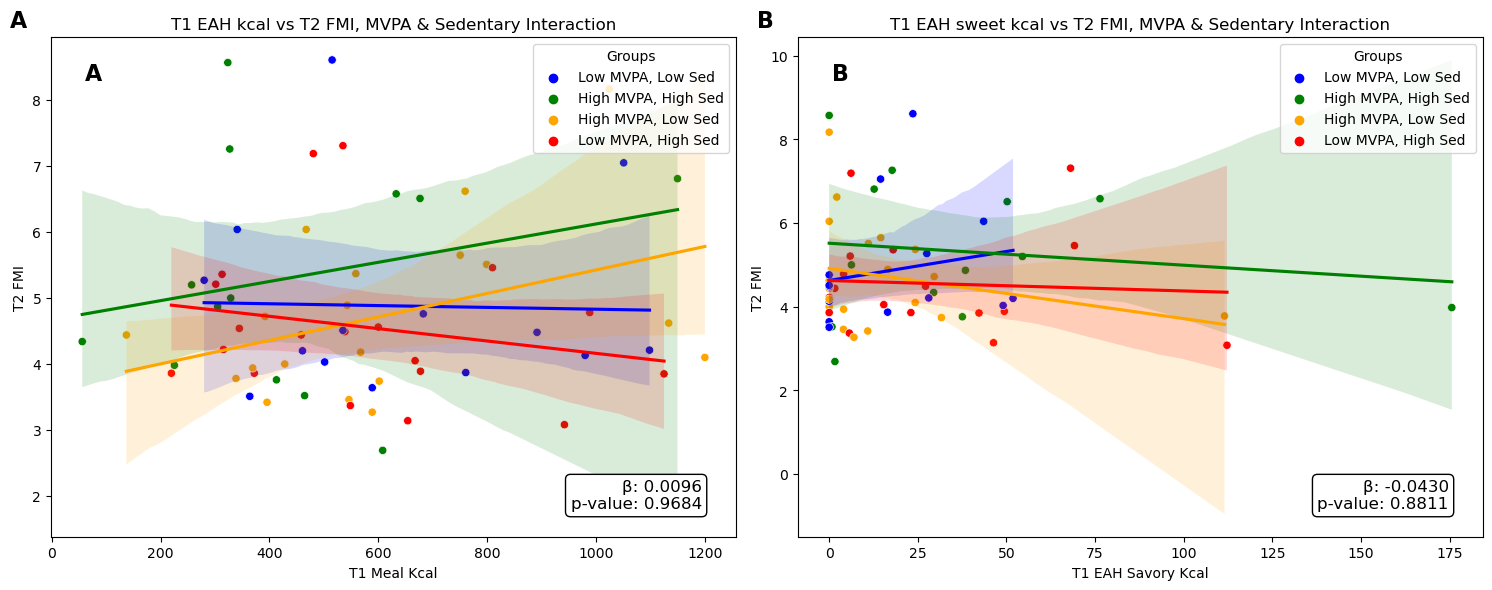

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the plotting function to handle four groups
def plot_with_regression_and_pvalue(x, y, hue1, hue2, data, ax, xlabel, ylabel, title, label, beta, pvalue):
    # Create a combined hue
    data['combined_hue'] = data[hue1].astype(str) + "_" + data[hue2].astype(str)
    
    # Define colors for the four groups
    colors = {
        '0_0': 'blue',    # Low MVPA, Low Sedentary
        '0_1': 'red',     # Low MVPA, High Sedentary
        '1_0': 'orange',  # High MVPA, Low Sedentary
        '1_1': 'green'    # High MVPA, High Sedentary
    }
    
    # Scatter plot with different colors
    scatter = sns.scatterplot(x=x, y=y, hue='combined_hue', palette=colors, data=data, ax=ax)
    
    # Regression lines for each group
    for combined_hue_level in data['combined_hue'].unique():
        sns.regplot(x=x, y=y, data=data[data['combined_hue'] == combined_hue_level], ax=ax, scatter=False, color=colors[combined_hue_level])
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
    ax.text(0.95, 0.05, f"β: {beta:.4f}\np-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Manual legend mapping to ensure correct labels
    legend_labels = {
        '0_0': 'Low MVPA, Low Sed',
        '0_1': 'Low MVPA, High Sed',
        '1_0': 'High MVPA, Low Sed',
        '1_1': 'High MVPA, High Sed'
    }
    
    # Extract the handles and labels from the scatter plot
    handles, labels = scatter.get_legend_handles_labels()

    # Map the extracted labels to the correct group names
    correct_labels = [legend_labels[label] for label in labels]
    
    # Update the legend with the correct group names
    ax.legend(handles=handles, labels=correct_labels, title='Groups', loc='upper right')

# Function to extract the beta and p-value for the last interaction term in the model
def extract_last_param_beta_pvalue(model):
    # Get the last term in the model's parameters (assuming it's the interaction term of interest)
    last_param = model.params.index[-1]
    beta = model.params[last_param]
    pvalue = model.pvalues[last_param]
    return last_param, beta, pvalue

# Extract values for each model
param_meal_kcal, beta_meal_kcal, pvalue_meal_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_meal_kcal)
param_eah_kcal, beta_eah_kcal, pvalue_eah_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_kcal)
param_eah_sweet_kcal, beta_eah_sweet_kcal, pvalue_eah_sweet_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_sweet_kcal)
param_eah_sav_kcal, beta_eah_sav_kcal, pvalue_eah_sav_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_sav_kcal)

# Store these values in dictionaries
beta_values = {
    f'v1_{param_eah_kcal}': beta_eah_kcal,
    f'v1_{param_eah_sweet_kcal}': beta_eah_sweet_kcal,
    f'v1_{param_meal_kcal}': beta_meal_kcal,
    f'v1_{param_eah_sav_kcal}': beta_eah_sav_kcal
}

p_values = {
    f'v1_{param_eah_kcal}': pvalue_eah_kcal,
    f'v1_{param_eah_sweet_kcal}': pvalue_eah_sweet_kcal,
    f'v1_{param_meal_kcal}': pvalue_meal_kcal,
    f'v1_{param_eah_sav_kcal}': pvalue_eah_sav_kcal
}

# Create subplots for EAH and EAH sweet (2x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_eah = ['A', 'B']

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_unscaled, axes1[0], 'T1 EAH Kcal', 'T2 FMI', 'MVPA & Sedentary Interaction', 
                                labels_eah[0], beta_values[f'v1_{param_eah_kcal}'], 
                                p_values[f'v1_{param_eah_kcal}'])
axes1[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_unscaled, axes1[1], 'T1 EAH Sweet Kcal', 'T2 FMI', 'MVPA & Sedentary Interaction', 
                                labels_eah[1], beta_values[f'v1_{param_eah_sweet_kcal}'], 
                                p_values[f'v1_{param_eah_sweet_kcal}'])
axes1[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (2x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_meal = ['A', 'B']

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_unscaled, axes2[0], 'T1 Meal Kcal', 'T2 FMI', 'T1 EAH kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                labels_meal[0], beta_values[f'v1_{param_meal_kcal}'], 
                                p_values[f'v1_{param_meal_kcal}'])
axes2[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_unscaled, axes2[1], 'T1 EAH Savory Kcal', 'T2 FMI', 'T1 EAH sweet kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                labels_meal[1], beta_values[f'v1_{param_eah_sav_kcal}'], 
                                p_values[f'v1_{param_eah_sav_kcal}'])
axes2[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()


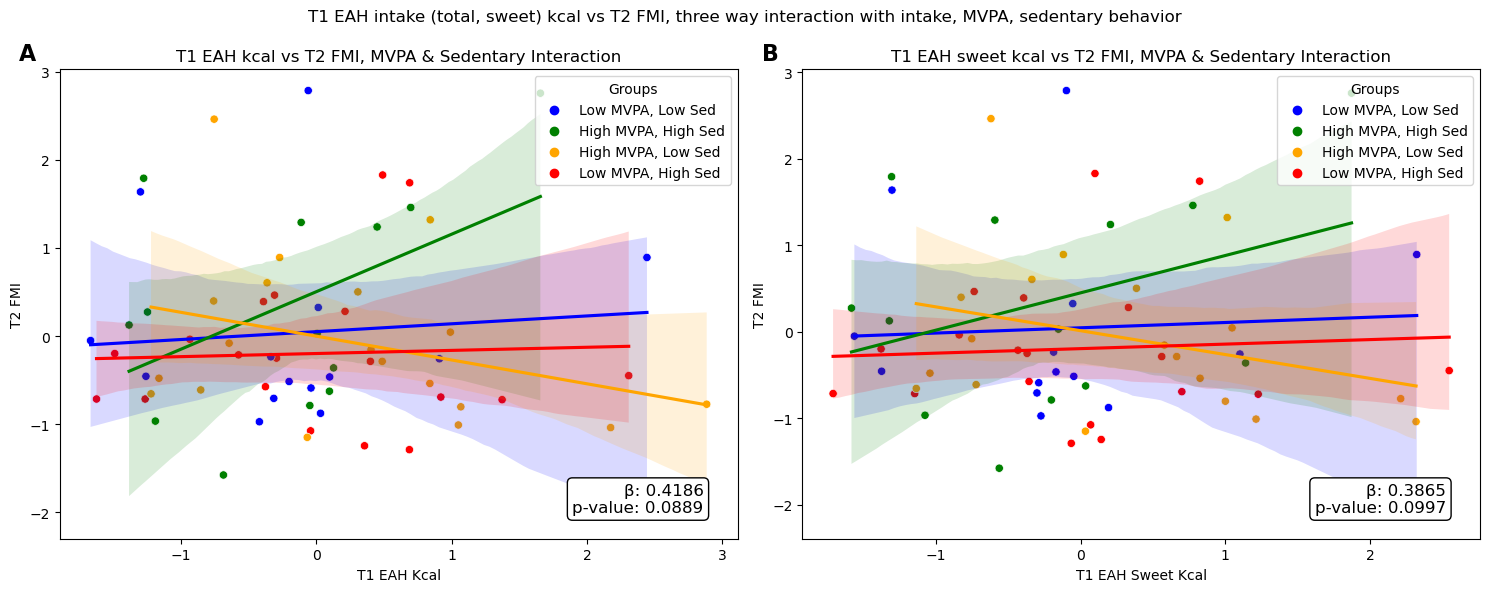

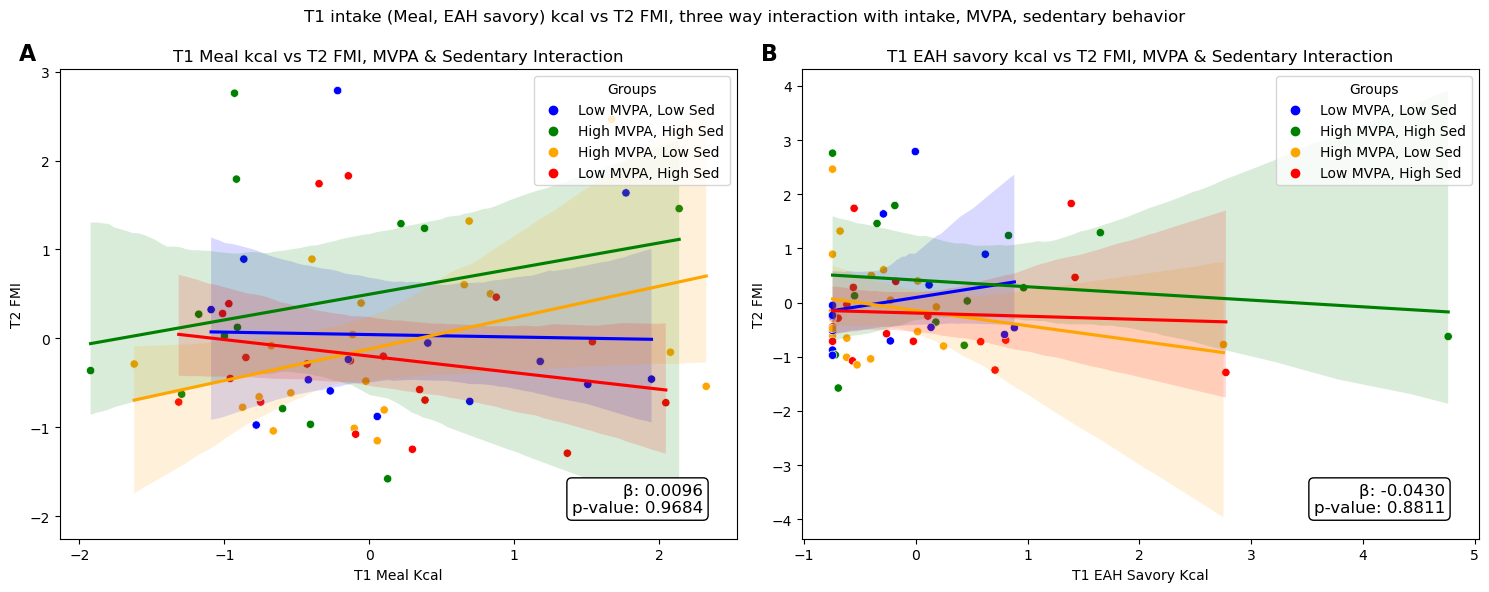

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the plotting function to handle four groups
def plot_with_regression_and_pvalue(x, y, hue1, hue2, data, ax, xlabel, ylabel, title, beta, pvalue):
    # Create a combined hue
    data['combined_hue'] = data[hue1].astype(str) + "_" + data[hue2].astype(str)
    
    # Define colors for the four groups
    colors = {
        '0_0': 'blue',    # Low MVPA, Low Sedentary
        '0_1': 'red',     # Low MVPA, High Sedentary
        '1_0': 'orange',  # High MVPA, Low Sedentary
        '1_1': 'green'    # High MVPA, High Sedentary
    }
    
    # Scatter plot with different colors
    scatter = sns.scatterplot(x=x, y=y, hue='combined_hue', palette=colors, data=data, ax=ax)
    
    # Regression lines for each group
    for combined_hue_level in data['combined_hue'].unique():
        sns.regplot(x=x, y=y, data=data[data['combined_hue'] == combined_hue_level], ax=ax, scatter=False, color=colors[combined_hue_level])
    
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.95, 0.05, f"β: {beta:.4f}\np-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Manual legend mapping to ensure correct labels
    legend_labels = {
        '0_0': 'Low MVPA, Low Sed',
        '0_1': 'Low MVPA, High Sed',
        '1_0': 'High MVPA, Low Sed',
        '1_1': 'High MVPA, High Sed'
    }
    
    # Extract the handles and labels from the scatter plot
    handles, labels = scatter.get_legend_handles_labels()

    # Map the extracted labels to the correct group names
    correct_labels = [legend_labels[label] for label in labels]
    
    # Update the legend with the correct group names
    ax.legend(handles=handles, labels=correct_labels, title='Groups', loc='upper right')

# Function to extract the beta and p-value for the last interaction term in the model
def extract_last_param_beta_pvalue(model):
    # Get the last term in the model's parameters (assuming it's the interaction term of interest)
    last_param = model.params.index[-1]
    beta = model.params[last_param]
    pvalue = model.pvalues[last_param]
    return last_param, beta, pvalue

# Extract values for each model
param_meal_kcal, beta_meal_kcal, pvalue_meal_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_meal_kcal)
param_eah_kcal, beta_eah_kcal, pvalue_eah_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_kcal)
param_eah_sweet_kcal, beta_eah_sweet_kcal, pvalue_eah_sweet_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_sweet_kcal)
param_eah_sav_kcal, beta_eah_sav_kcal, pvalue_eah_sav_kcal = extract_last_param_beta_pvalue(model_total_mvpa_sed_eah_sav_kcal)

# Store these values in dictionaries
beta_values = {
    f'v1_{param_eah_kcal}': beta_eah_kcal,
    f'v1_{param_eah_sweet_kcal}': beta_eah_sweet_kcal,
    f'v1_{param_meal_kcal}': beta_meal_kcal,
    f'v1_{param_eah_sav_kcal}': beta_eah_sav_kcal
}

p_values = {
    f'v1_{param_eah_kcal}': pvalue_eah_kcal,
    f'v1_{param_eah_sweet_kcal}': pvalue_eah_sweet_kcal,
    f'v1_{param_meal_kcal}': pvalue_meal_kcal,
    f'v1_{param_eah_sav_kcal}': pvalue_eah_sav_kcal
}

# Create subplots for EAH and EAH sweet (1x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_no_outliers, axes1[0], 'T1 EAH Kcal', 'T2 FMI', 'T1 EAH kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                beta_values[f'v1_{param_eah_kcal}'], 
                                p_values[f'v1_{param_eah_kcal}'])
axes1[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_no_outliers, axes1[1], 'T1 EAH Sweet Kcal', 'T2 FMI', 'T1 EAH sweet kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                beta_values[f'v1_{param_eah_sweet_kcal}'], 
                                p_values[f'v1_{param_eah_sweet_kcal}'])
axes1[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')
plt.suptitle("T1 EAH intake (total, sweet) kcal vs T2 FMI, three way interaction with intake, MVPA, sedentary behavior")
plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (1x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_no_outliers, axes2[0], 'T1 Meal Kcal', 'T2 FMI', 'T1 Meal kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                beta_values[f'v1_{param_meal_kcal}'], 
                                p_values[f'v1_{param_meal_kcal}'])
axes2[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_total_mvpa', 'median_split_sedentary', 
                                df_no_outliers, axes2[1], 'T1 EAH Savory Kcal', 'T2 FMI', 'T1 EAH savory kcal vs T2 FMI, MVPA & Sedentary Interaction', 
                                beta_values[f'v1_{param_eah_sav_kcal}'], 
                                p_values[f'v1_{param_eah_sav_kcal}'])
axes2[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')
plt.suptitle("T1 intake (Meal, EAH savory) kcal vs T2 FMI, three way interaction with intake, MVPA, sedentary behavior")
plt.tight_layout()
plt.show()


In [246]:
df_sedentary_0_mvpa_1_scaled = df_no_outliers[(df_no_outliers['median_split_sedentary'] == 0) & (df_no_outliers['median_split_total_mvpa'] == 1)]
df_sedentary_1_mvpa_0_scaled = df_no_outliers[(df_no_outliers['median_split_sedentary'] == 1) & (df_no_outliers['median_split_total_mvpa'] == 0)]
df_sedentary_1_mvpa_1_scaled = df_no_outliers[(df_no_outliers['median_split_sedentary'] == 1) & (df_no_outliers['median_split_total_mvpa'] == 1)]
df_sedentary_0_mvpa_0_scaled = df_no_outliers[(df_no_outliers['median_split_sedentary'] == 0) & (df_no_outliers['median_split_total_mvpa'] == 0)]


df_sedentary_0_mvpa_1_unscaled = df_unscaled[(df_unscaled['median_split_sedentary'] == 0) & (df_unscaled['median_split_total_mvpa'] == 1)]
df_sedentary_1_mvpa_0_unscaled = df_unscaled[(df_unscaled['median_split_sedentary'] == 1) & (df_unscaled['median_split_total_mvpa'] == 0)]
df_sedentary_1_mvpa_1_unscaled = df_unscaled[(df_unscaled['median_split_sedentary'] == 1) & (df_unscaled['median_split_total_mvpa'] == 1)]
df_sedentary_0_mvpa_0_unscaled = df_unscaled[(df_unscaled['median_split_sedentary'] == 0) & (df_unscaled['median_split_total_mvpa'] == 0)]


In [247]:
# Model with Total MVPA as moderator for kids with median_split_sedentary = 0 and median_split_mvpa_avg = 1
model_sedentary_0_mvpa_1_eah_sweet_kcal = smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal*median_split_total_mvpa*median_split_sedentary', data=df_sedentary_0_mvpa_1_scaled).fit()

print("Model with Total MVPA as moderator (Sedentary = 0, MVPA = 1) - EAH Sweet Kcal:")
print(model_sedentary_0_mvpa_1_eah_sweet_kcal.summary())

# Model with Total MVPA as moderator for kids with median_split_sedentary = 0 and median_split_mvpa_avg = 1
model_sedentary_0_mvpa_1_eah_kcal = smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff +avg_wear_time+  v1_eah_kcal*median_split_total_mvpa*median_split_sedentary', data=df_sedentary_0_mvpa_1_scaled).fit()

print("Model with Total MVPA as moderator (Sedentary = 0, MVPA = 1) - EAH Kcal:")
print(model_sedentary_0_mvpa_1_eah_kcal.summary())


Model with Total MVPA as moderator (Sedentary = 0, MVPA = 1) - EAH Sweet Kcal:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     10.22
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           0.000958
Time:                        15:58:51   Log-Likelihood:                -1.9871
No. Observations:                  19   AIC:                             23.97
Df Residuals:                       9   BIC:                             33.42
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975

c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [248]:
# Model with Total MVPA as moderator for kids with median_split_sedentary = 1 and median_split_mvpa_avg = 0
model_sedentary_1_mvpa_0_eah_sweet_kcal = smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal*median_split_total_mvpa*median_split_sedentary', data=df_sedentary_1_mvpa_0_scaled).fit()

print("Model with Total MVPA as moderator (Sedentary = 1, MVPA = 0) - EAH Sweet Kcal:")
print(model_sedentary_1_mvpa_0_eah_sweet_kcal.summary())

# Model with Total MVPA as moderator for kids with median_split_sedentary = 1 and median_split_mvpa_avg = 0
model_sedentary_1_mvpa_0_eah_kcal = smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_kcal*median_split_total_mvpa*median_split_sedentary', data=df_sedentary_1_mvpa_0_scaled).fit()

print("Model with Total MVPA as moderator (Sedentary = 1, MVPA = 0) - EAH Kcal:")
print(model_sedentary_1_mvpa_0_eah_kcal.summary())



Model with Total MVPA as moderator (Sedentary = 1, MVPA = 0) - EAH Sweet Kcal:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     9.017
Date:                Thu, 05 Sep 2024   Prob (F-statistic):            0.00236
Time:                        15:58:51   Log-Likelihood:                0.29281
No. Observations:                  19   AIC:                             21.41
Df Residuals:                       8   BIC:                             31.80
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975

c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\ybr5070\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


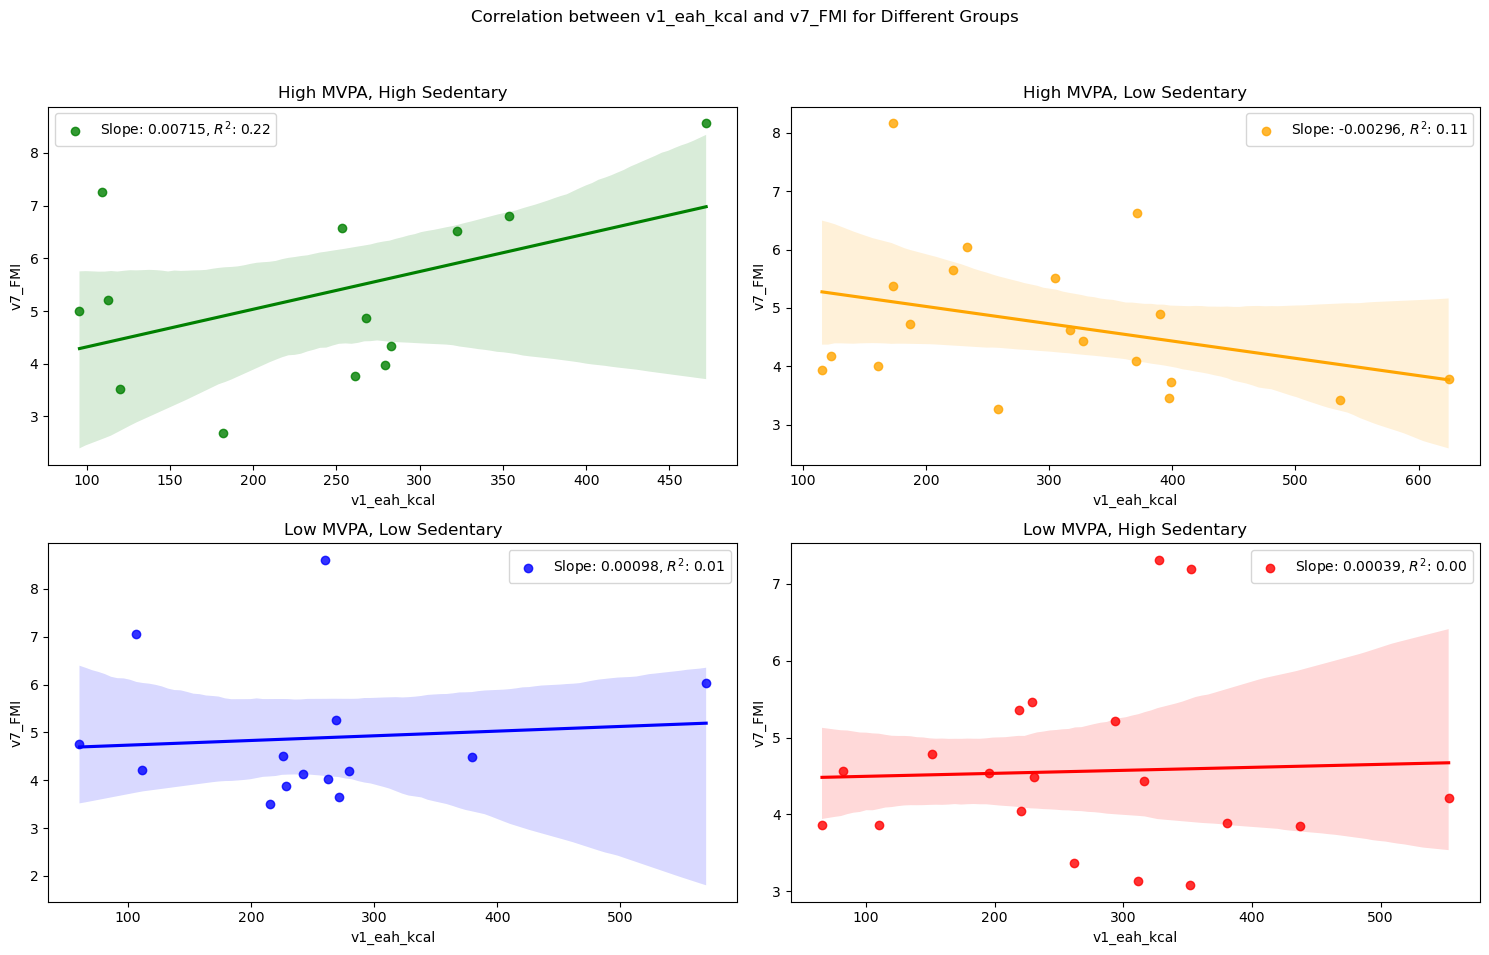

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Create four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for high sedentary, high MVPA group
slope_1_1, intercept_1_1, r_value_1_1, p_value_1_1, std_err_1_1 = linregress(df_sedentary_1_mvpa_1_unscaled['v1_eah_kcal'], df_sedentary_1_mvpa_1_unscaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_1_unscaled, 
            ax=axes[0, 0], label=f'Slope: {slope_1_1:.5f}, $R^2$: {r_value_1_1**2:.2f}', color='green')
axes[0, 0].set_title('High MVPA, High Sedentary')
axes[0, 0].set_xlabel('v1_eah_kcal')
axes[0, 0].set_ylabel('v7_FMI')
axes[0, 0].legend()

# Plot for low sedentary, high MVPA group
slope_0_1, intercept_0_1, r_value_0_1, p_value_0_1, std_err_0_1 = linregress(df_sedentary_0_mvpa_1_unscaled['v1_eah_kcal'], df_sedentary_0_mvpa_1_unscaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_1_unscaled, 
            ax=axes[0, 1], label=f'Slope: {slope_0_1:.5f}, $R^2$: {r_value_0_1**2:.2f}', color='orange')
axes[0, 1].set_title('High MVPA, Low Sedentary')
axes[0, 1].set_xlabel('v1_eah_kcal')
axes[0, 1].set_ylabel('v7_FMI')
axes[0, 1].legend()

# Plot for low sedentary, low MVPA group
slope_0_0, intercept_0_0, r_value_0_0, p_value_0_0, std_err_0_0 = linregress(df_sedentary_0_mvpa_0_unscaled['v1_eah_kcal'], df_sedentary_0_mvpa_0_unscaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_0_unscaled, 
            ax=axes[1, 0], label=f'Slope: {slope_0_0:.5f}, $R^2$: {r_value_0_0**2:.2f}', color='blue')
axes[1, 0].set_title('Low MVPA, Low Sedentary')
axes[1, 0].set_xlabel('v1_eah_kcal')
axes[1, 0].set_ylabel('v7_FMI')
axes[1, 0].legend()

# Plot for high sedentary, low MVPA group
slope_1_0, intercept_1_0, r_value_1_0, p_value_1_0, std_err_1_0 = linregress(df_sedentary_1_mvpa_0_unscaled['v1_eah_kcal'], df_sedentary_1_mvpa_0_unscaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_0_unscaled, 
            ax=axes[1, 1], label=f'Slope: {slope_1_0:.5f}, $R^2$: {r_value_1_0**2:.2f}', color='red')
axes[1, 1].set_title('Low MVPA, High Sedentary')
axes[1, 1].set_xlabel('v1_eah_kcal')
axes[1, 1].set_ylabel('v7_FMI')
axes[1, 1].legend()

plt.suptitle('Correlation between v1_eah_kcal and v7_FMI for Different Groups')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


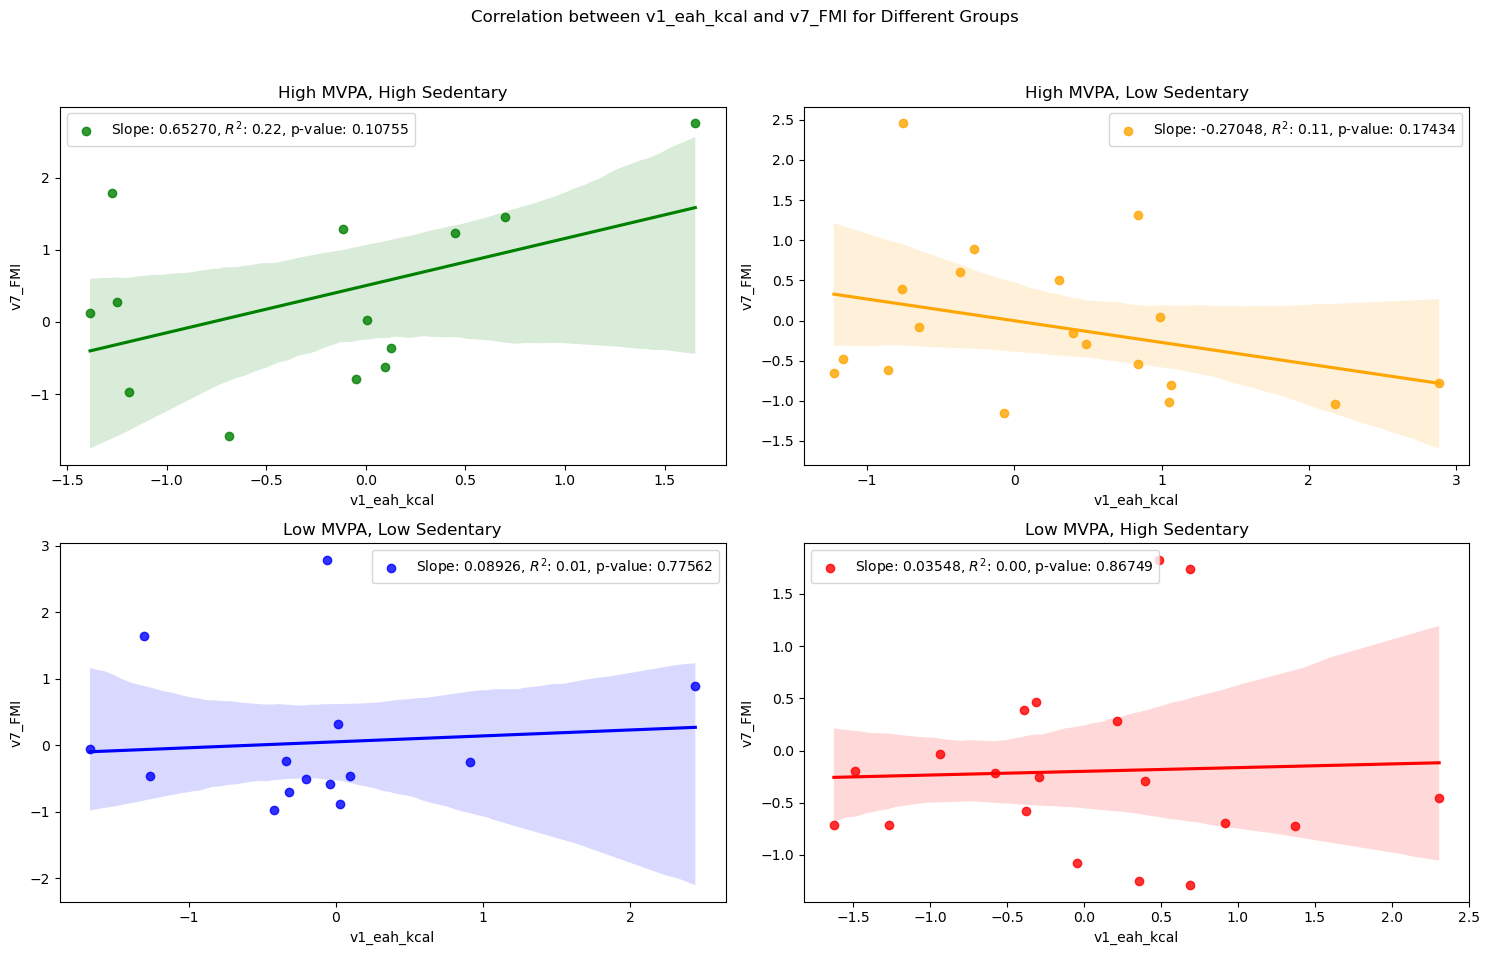

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Create four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for high sedentary, high MVPA group
slope_1_1, intercept_1_1, r_value_1_1, p_value_1_1, std_err_1_1 = linregress(df_sedentary_1_mvpa_1_scaled['v1_eah_kcal'], df_sedentary_1_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_1_scaled, 
            ax=axes[0, 0], label=f'Slope: {slope_1_1:.5f}, $R^2$: {r_value_1_1**2:.2f}, p-value: {p_value_1_1:.5f}', color='green')
axes[0, 0].set_title('High MVPA, High Sedentary')
axes[0, 0].set_xlabel('v1_eah_kcal')
axes[0, 0].set_ylabel('v7_FMI')
axes[0, 0].legend()

# Plot for low sedentary, high MVPA group
slope_0_1, intercept_0_1, r_value_0_1, p_value_0_1, std_err_0_1 = linregress(df_sedentary_0_mvpa_1_scaled['v1_eah_kcal'], df_sedentary_0_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_1_scaled, 
            ax=axes[0, 1], label=f'Slope: {slope_0_1:.5f}, $R^2$: {r_value_0_1**2:.2f}, p-value: {p_value_0_1:.5f}', color='orange')
axes[0, 1].set_title('High MVPA, Low Sedentary')
axes[0, 1].set_xlabel('v1_eah_kcal')
axes[0, 1].set_ylabel('v7_FMI')
axes[0, 1].legend()

# Plot for low sedentary, low MVPA group
slope_0_0, intercept_0_0, r_value_0_0, p_value_0_0, std_err_0_0 = linregress(df_sedentary_0_mvpa_0_scaled['v1_eah_kcal'], df_sedentary_0_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_0_scaled, 
            ax=axes[1, 0], label=f'Slope: {slope_0_0:.5f}, $R^2$: {r_value_0_0**2:.2f}, p-value: {p_value_0_0:.5f}', color='blue')
axes[1, 0].set_title('Low MVPA, Low Sedentary')
axes[1, 0].set_xlabel('v1_eah_kcal')
axes[1, 0].set_ylabel('v7_FMI')
axes[1, 0].legend()

# Plot for high sedentary, low MVPA group
slope_1_0, intercept_1_0, r_value_1_0, p_value_1_0, std_err_1_0 = linregress(df_sedentary_1_mvpa_0_scaled['v1_eah_kcal'], df_sedentary_1_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_0_scaled, 
            ax=axes[1, 1], label=f'Slope: {slope_1_0:.5f}, $R^2$: {r_value_1_0**2:.2f}, p-value: {p_value_1_0:.5f}', color='red')
axes[1, 1].set_title('Low MVPA, High Sedentary')
axes[1, 1].set_xlabel('v1_eah_kcal')
axes[1, 1].set_ylabel('v7_FMI')
axes[1, 1].legend()

plt.suptitle('Correlation between v1_eah_kcal and v7_FMI for Different Groups')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


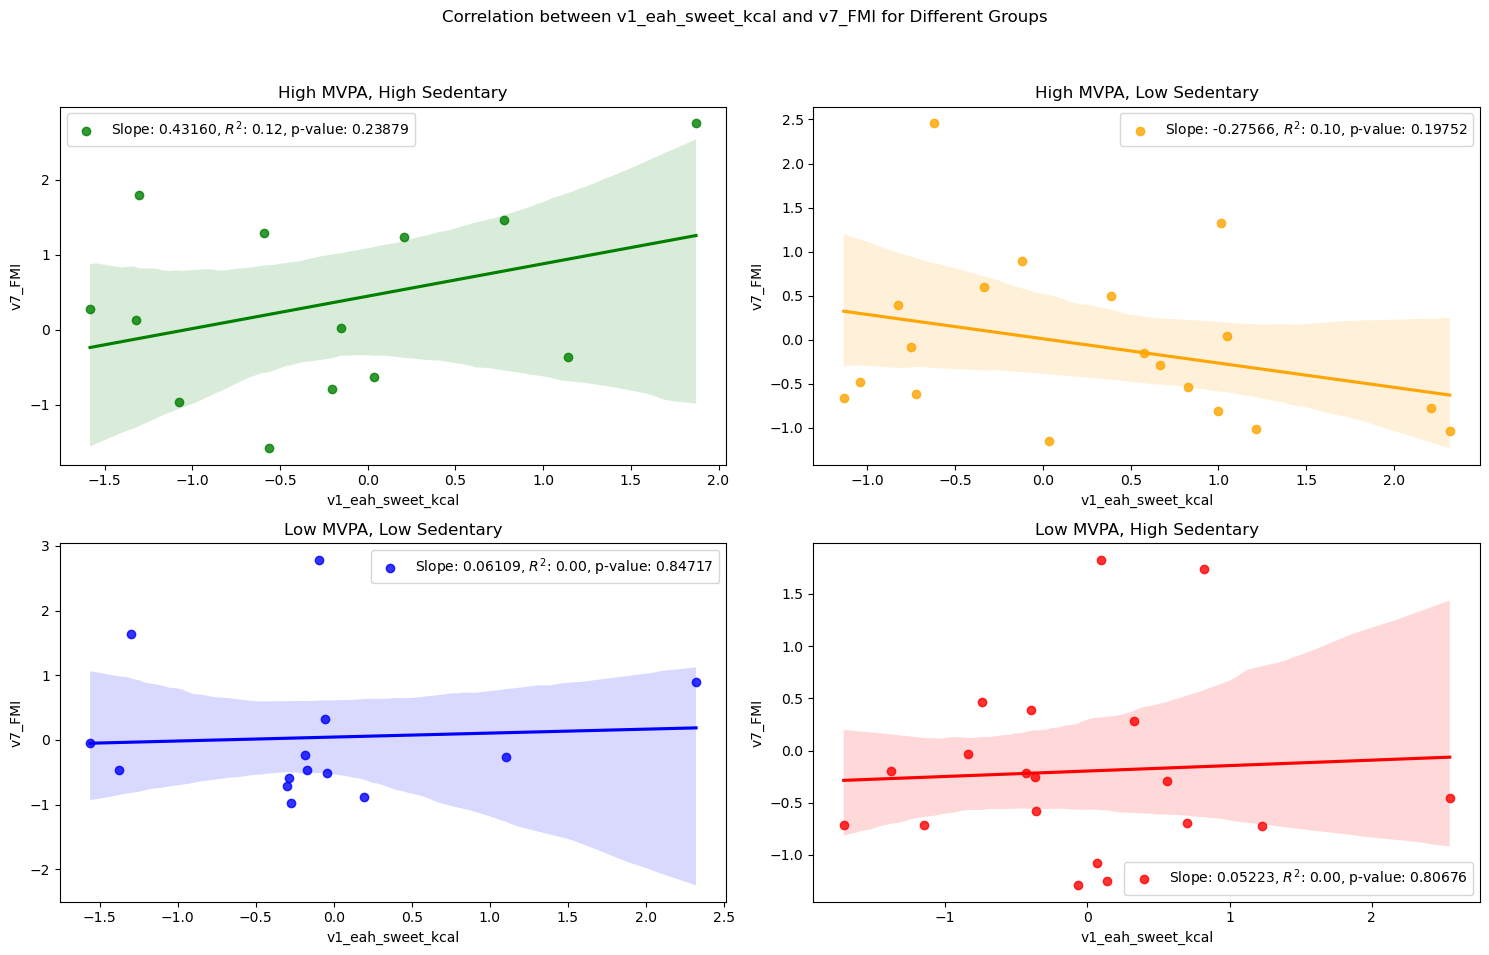

In [251]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Create four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for high sedentary, high MVPA group
slope_1_1, intercept_1_1, r_value_1_1, p_value_1_1, std_err_1_1 = linregress(df_sedentary_1_mvpa_1_scaled['v1_eah_sweet_kcal'], df_sedentary_1_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_1_scaled, 
            ax=axes[0, 0], label=f'Slope: {slope_1_1:.5f}, $R^2$: {r_value_1_1**2:.2f}, p-value: {p_value_1_1:.5f}', color='green')
axes[0, 0].set_title('High MVPA, High Sedentary')
axes[0, 0].set_xlabel('v1_eah_sweet_kcal')
axes[0, 0].set_ylabel('v7_FMI')
axes[0, 0].legend()

# Plot for low sedentary, high MVPA group
slope_0_1, intercept_0_1, r_value_0_1, p_value_0_1, std_err_0_1 = linregress(df_sedentary_0_mvpa_1_scaled['v1_eah_sweet_kcal'], df_sedentary_0_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_1_scaled, 
            ax=axes[0, 1], label=f'Slope: {slope_0_1:.5f}, $R^2$: {r_value_0_1**2:.2f}, p-value: {p_value_0_1:.5f}', color='orange')
axes[0, 1].set_title('High MVPA, Low Sedentary')
axes[0, 1].set_xlabel('v1_eah_sweet_kcal')
axes[0, 1].set_ylabel('v7_FMI')
axes[0, 1].legend()

# Plot for low sedentary, low MVPA group
slope_0_0, intercept_0_0, r_value_0_0, p_value_0_0, std_err_0_0 = linregress(df_sedentary_0_mvpa_0_scaled['v1_eah_sweet_kcal'], df_sedentary_0_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_0_scaled, 
            ax=axes[1, 0], label=f'Slope: {slope_0_0:.5f}, $R^2$: {r_value_0_0**2:.2f}, p-value: {p_value_0_0:.5f}', color='blue')
axes[1, 0].set_title('Low MVPA, Low Sedentary')
axes[1, 0].set_xlabel('v1_eah_sweet_kcal')
axes[1, 0].set_ylabel('v7_FMI')
axes[1, 0].legend()

# Plot for high sedentary, low MVPA group
slope_1_0, intercept_1_0, r_value_1_0, p_value_1_0, std_err_1_0 = linregress(df_sedentary_1_mvpa_0_scaled['v1_eah_sweet_kcal'], df_sedentary_1_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_0_scaled, 
            ax=axes[1, 1], label=f'Slope: {slope_1_0:.5f}, $R^2$: {r_value_1_0**2:.2f}, p-value: {p_value_1_0:.5f}', color='red')
axes[1, 1].set_title('Low MVPA, High Sedentary')
axes[1, 1].set_xlabel('v1_eah_sweet_kcal')
axes[1, 1].set_ylabel('v7_FMI')
axes[1, 1].legend()

plt.suptitle('Correlation between v1_eah_sweet_kcal and v7_FMI for Different Groups')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


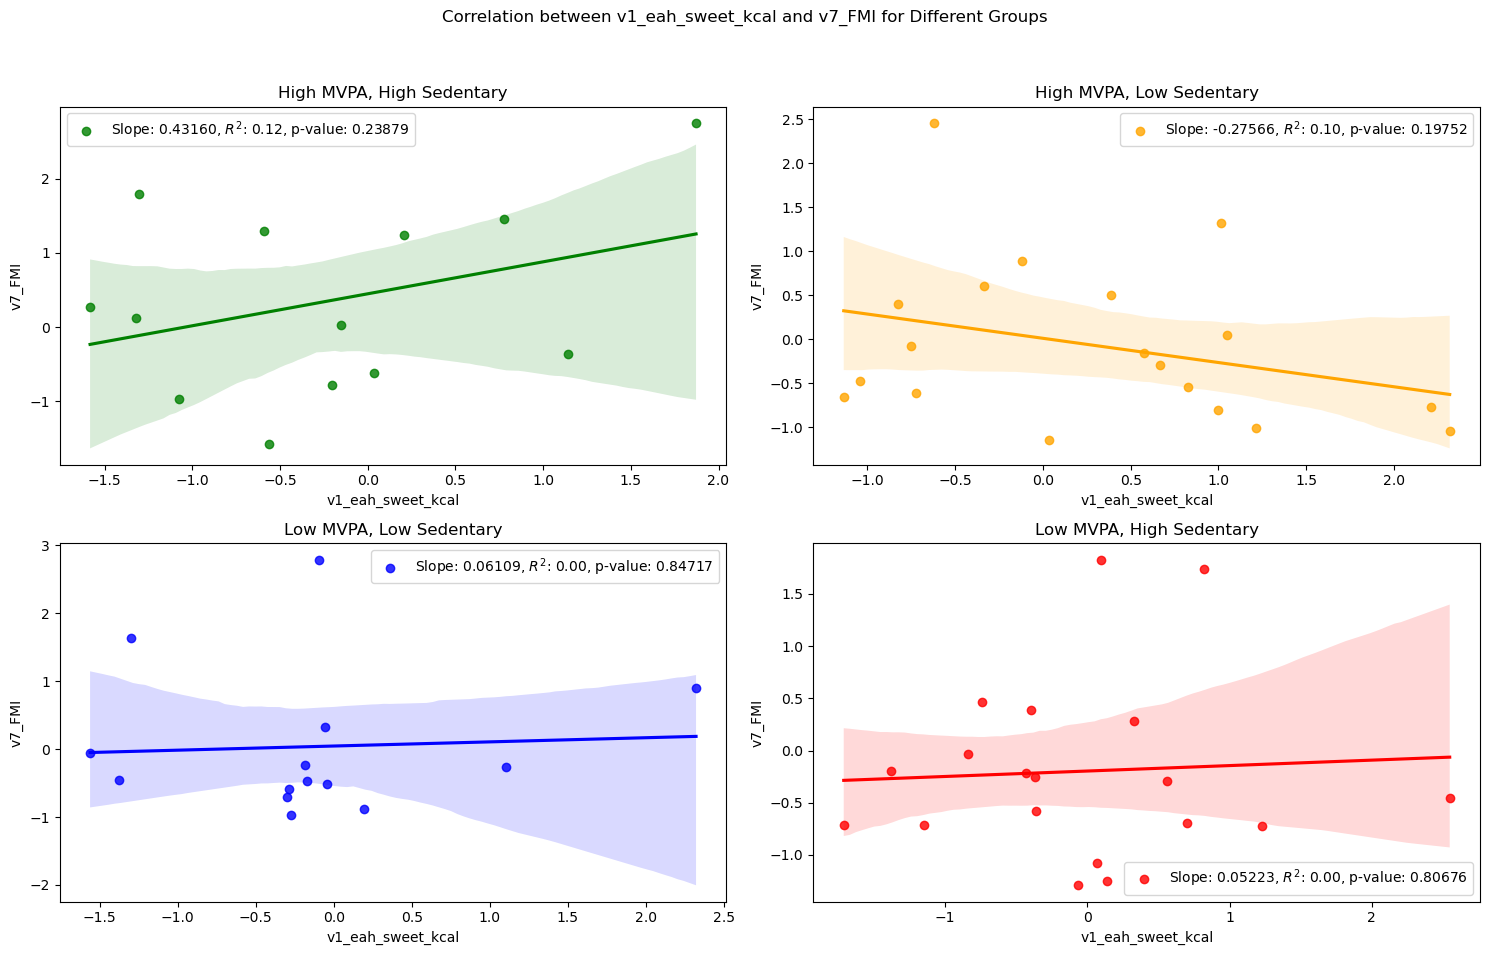

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Create four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for high sedentary, high MVPA group
slope_1_1, intercept_1_1, r_value_1_1, p_value_1_1, std_err_1_1 = linregress(df_sedentary_1_mvpa_1_scaled['v1_eah_sweet_kcal'], df_sedentary_1_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_1_scaled, 
            ax=axes[0, 0], label=f'Slope: {slope_1_1:.5f}, $R^2$: {r_value_1_1**2:.2f}, p-value: {p_value_1_1:.5f}', color='green')
axes[0, 0].set_title('High MVPA, High Sedentary')
axes[0, 0].set_xlabel('v1_eah_sweet_kcal')
axes[0, 0].set_ylabel('v7_FMI')
axes[0, 0].legend()

# Plot for low sedentary, high MVPA group
slope_0_1, intercept_0_1, r_value_0_1, p_value_0_1, std_err_0_1 = linregress(df_sedentary_0_mvpa_1_scaled['v1_eah_sweet_kcal'], df_sedentary_0_mvpa_1_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_1_scaled, 
            ax=axes[0, 1], label=f'Slope: {slope_0_1:.5f}, $R^2$: {r_value_0_1**2:.2f}, p-value: {p_value_0_1:.5f}', color='orange')
axes[0, 1].set_title('High MVPA, Low Sedentary')
axes[0, 1].set_xlabel('v1_eah_sweet_kcal')
axes[0, 1].set_ylabel('v7_FMI')
axes[0, 1].legend()

# Plot for low sedentary, low MVPA group
slope_0_0, intercept_0_0, r_value_0_0, p_value_0_0, std_err_0_0 = linregress(df_sedentary_0_mvpa_0_scaled['v1_eah_sweet_kcal'], df_sedentary_0_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_0_mvpa_0_scaled, 
            ax=axes[1, 0], label=f'Slope: {slope_0_0:.5f}, $R^2$: {r_value_0_0**2:.2f}, p-value: {p_value_0_0:.5f}', color='blue')
axes[1, 0].set_title('Low MVPA, Low Sedentary')
axes[1, 0].set_xlabel('v1_eah_sweet_kcal')
axes[1, 0].set_ylabel('v7_FMI')
axes[1, 0].legend()

# Plot for high sedentary, low MVPA group
slope_1_0, intercept_1_0, r_value_1_0, p_value_1_0, std_err_1_0 = linregress(df_sedentary_1_mvpa_0_scaled['v1_eah_sweet_kcal'], df_sedentary_1_mvpa_0_scaled['v7_FMI'])
sns.regplot(x='v1_eah_sweet_kcal', y='v7_FMI', data=df_sedentary_1_mvpa_0_scaled, 
            ax=axes[1, 1], label=f'Slope: {slope_1_0:.5f}, $R^2$: {r_value_1_0**2:.2f}, p-value: {p_value_1_0:.5f}', color='red')
axes[1, 1].set_title('Low MVPA, High Sedentary')
axes[1, 1].set_xlabel('v1_eah_sweet_kcal')
axes[1, 1].set_ylabel('v7_FMI')
axes[1, 1].legend()

plt.suptitle('Correlation between v1_eah_sweet_kcal and v7_FMI for Different Groups')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Fisher Z  test - EAH kcal

In [253]:
from scipy.stats import linregress, fisher_exact, zscore
from scipy.stats import linregress, norm
import numpy as np

# Extract data for each group
x_orange = df_sedentary_0_mvpa_1_scaled['v1_eah_kcal']
y_orange = df_sedentary_0_mvpa_1_scaled['v7_FMI']

x_green = df_sedentary_1_mvpa_1_scaled['v1_eah_kcal']
y_green = df_sedentary_1_mvpa_1_scaled['v7_FMI']

# Perform linear regression for each group
slope_orange, intercept_orange, r_value_orange, p_value_orange, std_err_orange = linregress(x_orange, y_orange)
slope_green, intercept_green, r_value_green, p_value_green, std_err_green = linregress(x_green, y_green)

# Sample sizes
n_orange = len(x_orange)
n_green = len(x_green)

# Output slopes and sample sizes
print(f"Slope for High MVPA, Low Sedentary (Orange): {slope_orange}")
print(f"Slope for High MVPA, High Sedentary (Green): {slope_green}")
print(f"Sample size for Orange group: {n_orange}")
print(f"Sample size for Green group: {n_green}")

# Compute Fisher Z-test between the two correlations
# Fisher Z-transformation
z_orange = np.arctanh(r_value_orange)
z_green = np.arctanh(r_value_green)

# Fisher Z-test statistic
z_score = (z_orange - z_green) / np.sqrt(1/(n_orange - 3) + 1/(n_green - 3))

# Two-tailed p-value from Z-score
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score for Fisher Z-test: {z_score}")
print(f"P-value for Fisher Z-test: {p_value}")

Slope for High MVPA, Low Sedentary (Orange): -0.27048120199543957
Slope for High MVPA, High Sedentary (Green): 0.6526957846281872
Sample size for Orange group: 19
Sample size for Green group: 13
Z-score for Fisher Z-test: -2.0931080365292662
P-value for Fisher Z-test: 0.03633951147623171


In [254]:
from scipy.stats import linregress, fisher_exact, zscore
from scipy.stats import linregress, norm
import numpy as np

# Extract data for each group
x_orange = df_sedentary_0_mvpa_1_unscaled['v1_eah_kcal']
y_orange = df_sedentary_0_mvpa_1_unscaled['v7_FMI']

x_green = df_sedentary_1_mvpa_1_unscaled['v1_eah_kcal']
y_green = df_sedentary_1_mvpa_1_unscaled['v7_FMI']

# Perform linear regression for each group
slope_orange, intercept_orange, r_value_orange, p_value_orange, std_err_orange = linregress(x_orange, y_orange)
slope_green, intercept_green, r_value_green, p_value_green, std_err_green = linregress(x_green, y_green)

# Sample sizes
n_orange = len(x_orange)
n_green = len(x_green)

# Output slopes and sample sizes
print(f"Slope for High MVPA, Low Sedentary (Orange): {slope_orange}")
print(f"Slope for High MVPA, High Sedentary (Green): {slope_green}")
print(f"Sample size for Orange group: {n_orange}")
print(f"Sample size for Green group: {n_green}")

# Compute Fisher Z-test between the two correlations
# Fisher Z-transformation
z_orange = np.arctanh(r_value_orange)
z_green = np.arctanh(r_value_green)

# Fisher Z-test statistic
z_score = (z_orange - z_green) / np.sqrt(1/(n_orange - 3) + 1/(n_green - 3))

# Two-tailed p-value from Z-score
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score for Fisher Z-test: {z_score}")
print(f"P-value for Fisher Z-test: {p_value}")

Slope for High MVPA, Low Sedentary (Orange): -0.002961631585339593
Slope for High MVPA, High Sedentary (Green): 0.007146686857023951
Sample size for Orange group: 19
Sample size for Green group: 13
Z-score for Fisher Z-test: -2.093108036529266
P-value for Fisher Z-test: 0.03633951147623171


In [255]:
from scipy.stats import linregress, fisher_exact, zscore
from scipy.stats import linregress, norm
import numpy as np

# Extract data for each group
x_orange = df_sedentary_0_mvpa_1_unscaled['v1_eah_sweet_kcal']
y_orange = df_sedentary_0_mvpa_1_unscaled['v7_FMI']

x_green = df_sedentary_1_mvpa_1_unscaled['v1_eah_sweet_kcal']
y_green = df_sedentary_1_mvpa_1_unscaled['v7_FMI']

# Perform linear regression for each group
slope_orange, intercept_orange, r_value_orange, p_value_orange, std_err_orange = linregress(x_orange, y_orange)
slope_green, intercept_green, r_value_green, p_value_green, std_err_green = linregress(x_green, y_green)

# Sample sizes
n_orange = len(x_orange)
n_green = len(x_green)

# Output slopes and sample sizes
print(f"Slope for High MVPA, Low Sedentary (Orange): {slope_orange}")
print(f"Slope for High MVPA, High Sedentary (Green): {slope_green}")
print(f"Sample size for Orange group: {n_orange}")
print(f"Sample size for Green group: {n_green}")

# Compute Fisher Z-test between the two correlations
# Fisher Z-transformation
z_orange = np.arctanh(r_value_orange)
z_green = np.arctanh(r_value_green)

# Fisher Z-test statistic
z_score = (z_orange - z_green) / np.sqrt(1/(n_orange - 3) + 1/(n_green - 3))

# Two-tailed p-value from Z-score
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score for Fisher Z-test: {z_score}")
print(f"P-value for Fisher Z-test: {p_value}")


Slope for High MVPA, Low Sedentary (Orange): -0.003118833612545604
Slope for High MVPA, High Sedentary (Green): 0.00488323111593551
Sample size for Orange group: 19
Sample size for Green group: 13
Z-score for Fisher Z-test: -1.7043428294329754
P-value for Fisher Z-test: 0.08831705788908817


In [256]:
from scipy.stats import linregress, fisher_exact, zscore
from scipy.stats import linregress, norm
import numpy as np

# Extract data for each group
x_orange = df_sedentary_0_mvpa_1_scaled['v1_eah_sweet_kcal']
y_orange = df_sedentary_0_mvpa_1_scaled['v7_FMI']

x_green = df_sedentary_1_mvpa_1_scaled['v1_eah_sweet_kcal']
y_green = df_sedentary_1_mvpa_1_scaled['v7_FMI']

# Perform linear regression for each group
slope_orange, intercept_orange, r_value_orange, p_value_orange, std_err_orange = linregress(x_orange, y_orange)
slope_green, intercept_green, r_value_green, p_value_green, std_err_green = linregress(x_green, y_green)

# Sample sizes
n_orange = len(x_orange)
n_green = len(x_green)

# Output slopes and sample sizes
print(f"Slope for High MVPA, Low Sedentary (Orange): {slope_orange}")
print(f"Slope for High MVPA, High Sedentary (Green): {slope_green}")
print(f"Sample size for Orange group: {n_orange}")
print(f"Sample size for Green group: {n_green}")

# Compute Fisher Z-test between the two correlations
# Fisher Z-transformation
z_orange = np.arctanh(r_value_orange)
z_green = np.arctanh(r_value_green)

# Fisher Z-test statistic
z_score = (z_orange - z_green) / np.sqrt(1/(n_orange - 3) + 1/(n_green - 3))

# Two-tailed p-value from Z-score
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f"Z-score for Fisher Z-test: {z_score}")
print(f"P-value for Fisher Z-test: {p_value}")


Slope for High MVPA, Low Sedentary (Orange): -0.27565591117114135
Slope for High MVPA, High Sedentary (Green): 0.43160094123257403
Sample size for Orange group: 19
Sample size for Green group: 13
Z-score for Fisher Z-test: -1.704342829432975
P-value for Fisher Z-test: 0.08831705788908817


# continuous analysis

In [257]:
#from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Assuming the Excel file is named 'data.xlsx' and located in the current directory
file_path ="EAH_Database_all.xlsx"
df = pd.read_excel(file_path)

#replacing any statistical outliers with mean values
outlier_cols=[
       'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g','v1_freddy_pre_eah', 'v7_freddy_pre_eah']

In [258]:
import numpy as np

# Set the lower and upper percentiles
lower_percentile = 0.05
upper_percentile = 0.95

# Apply Winsorization
for col in outlier_cols:
    lower_limit = df[col].quantile(lower_percentile)
    upper_limit = df[col].quantile(upper_percentile)
    df[col] = np.where(df[col] < lower_limit, lower_limit, df[col])
    df[col] = np.where(df[col] > upper_limit, upper_limit, df[col])

In [259]:
def remove_subjects_with_outliers(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Filter out rows where outliers exist in the specified columns
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Usage
outlier_cols = ['mvpa_simple_avg','sed_simple_avg']
df = remove_subjects_with_outliers(df, outlier_cols)

In [260]:
df_no_outliers=filtered_df.copy()

In [261]:
import pandas as pd

# df_no_outliers is your DataFrame
mean_sd_stats = df_no_outliers[['mvpa_simple_avg','sed_simple_avg']].agg(['mean', 'std', 'min', 'max'])

# Formatting the output to two decimal places
mean_sd_stats = mean_sd_stats.map(lambda x: f"{x:.2f}")

print(mean_sd_stats)

     mvpa_simple_avg sed_simple_avg
mean          429.28         754.04
std            67.17          96.22
min           240.71         429.67
max           575.74         927.40


In [262]:
# Filtering the dataset for subjects with actual values in the specified columns
filtered_df = df.dropna(subset=['mvpa_simple_avg','sed_simple_avg'])

# Printing the first few rows of the filtered dataset to confirm
print(filtered_df[['mvpa_simple_avg','sed_simple_avg']].head())

# You can also get the count of remaining subjects
remaining_subjects_count = filtered_df.shape[0]
print(f"Number of subjects with actual values: {remaining_subjects_count}")

   mvpa_simple_avg  sed_simple_avg
0       354.722222      608.388889
1       484.027778      812.777778
2       473.333333      824.261905
5       396.366667      429.666667
6       478.571429      724.583333
Number of subjects with actual values: 65


In [263]:
# Standardize the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_columns = ['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time','mvpa_simple_avg','sed_simple_avg']
df_no_outliers[scaled_columns] = scaler.fit_transform(df_no_outliers[scaled_columns])

# Save the original scaled data for plotting
df_unscaled = df_no_outliers.copy()


# Inverse transform the scaled variables for plotting
df_unscaled[['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time','mvpa_simple_avg','sed_simple_avg']] = scaler.inverse_transform(df_unscaled[scaled_columns])

In [264]:
# Recoding the income column
df_no_outliers['income'] = df_no_outliers['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_no_outliers['parent_ed'] = df_no_outliers['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

In [265]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_no_outliers['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_no_outliers.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_no_outliers = pd.concat([df_no_outliers, tanner_dummies], axis=1)

In [266]:
# Fit regression models
model_total_mvpa_eah_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_kcal*mvpa_simple_avg*sed_simple_avg', data=df_no_outliers).fit()

# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_eah_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     18.60
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.55e-15
Time:                        15:58:54   Log-Likelihood:                -28.067
No. Observations:                  65   AIC:                             90.13
Df Residuals:                      48   BIC:                             127.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

In [267]:
# Fit regression models
model_total_mvpa_eah_sweet_kcal= smf.ols('v7_FMI ~ v1_FMI + sex+ risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal*mvpa_simple_avg*sed_simple_avg', data=df_no_outliers).fit()

# Print model summaries
print("Model with Total MVPA as moderator:")
print(model_total_mvpa_eah_sweet_kcal.summary())

Model with Total MVPA as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     18.75
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           2.19e-15
Time:                        15:58:54   Log-Likelihood:                -27.847
No. Observations:                  65   AIC:                             89.69
Df Residuals:                      48   BIC:                             126.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------